# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)
*Дедлайн -- 30 декабря.*

*Захаркин Илья (ФИВТ МФТИ)*

## Домашнее задание № 7. Часть 2

### Transfer Learning in PyTorch

***Перед выполнением данного задания рекомендуется сделать [Часть 1](https://github.com/deepmipt/dlschl/blob/master/materials/homeworks/hw07/%5Bhw7_1%5Dpytorch_convnet_intro.ipynb).***

Надо же! Вы добрались до последнего домашнего задания 1-ой половины курса, посвящённой основам нейросетей и свёрточным нейросетям. Мы в шоке!

Но, раз уж Вы здесь, пора научиться магии, которая позволит Вам вздохнуть с облегчением и сказать: "Я точно прошёл этот курс не зря". Это **Transfer Learning**.

*Замечание:* За ответы на вопросы в этом ноутбуке проверяющий в праве начислять небольшое количество баллов (суммарно - не больше 2 баллов за все вопросы). Так что смело излагайте свои мысли, гуглите, изучайте, всё пойдёт Вам на пользу :)

### Введение

Как Вы уже знаете (если не знаете, рекомендуем посмотреть [5-ую](https://www.youtube.com/watch?v=cAJp2hh-_q8&t=4831s) и [6-ую](https://www.youtube.com/watch?v=RVk2RUW9Euk&t=40s) лекции нашего курса), в современных задачах обработки изображений, будь то задача обнаружения объектов, задача распознавания образов, задача сегментации (выделения сущностей на картинке), задача классификации изображений и другие, всё чаще используют **свёрточные нейросети** (*Convolutional Neural Networks*, *CNN*).

Они показывают очень хорошие результаты, за ними стоит как [математический аппарат](https://stats.stackexchange.com/questions/269854/are-there-mathematical-reasons-for-convolution-in-neural-networks-beyond-expedie), так и эвристики, полученные опытным путём.

На [лекции](https://www.youtube.com/watch?v=RVk2RUW9Euk&t=40s) было рассказано про различные виды архитектур свёрточных нейростей - *LeNet*, *AlexNet*, *GoogLeNet*, *Inception*, *ResNet*.. 
В данном задании Вам предстоит для каждой из этих моделей использовать технику **Transfer Learning**.  

* **Transfer Learning** - это процесс дообучения на **новых данных** какой-либо нейросети, уже обученной до этого на других данных, обычно на каком-нибудь хорошем, большом (миллионы картинок) датасете (например, [ImageNet](http://www.image-net.org/) ~ 14 млн картинок).

### Идея

Давайте вспомним общую архитектуру CNN:

<img src="https://www.kernix.com/doc/data/cnn.png">

С помощью операций *свёртки (convolution)* и *пулинга (pooling)* всё, что расположено до этапа *classification*, по сути **извлекает признаки из объектов, подающихся на вход** (картинок, в данном случае). То есть вместо того, чтобы самим пытаться как-то описать картинки для хорошей работы классификатора, мы предоставляем заняться этим нейросети (обучая её методом обратного распространения ошибки ([лекция 4](https://www.youtube.com/watch?v=HZDOhHAg5_g))).

**Вопрос (творческий):**  А какие признаки для картинок приходят Вам в голову? (считать, что картинки цветные (3 канала), все одинакового размера)

**Ответ:** 1 слой - edge detection, 2 слой small objects; 3 слой big patters

### Описание метода (много текста, но он очень полезен!!)

Представим теперь, что eсть свой набор данных, и Вы хотите научить сеть классифицировать объекты из Вашей выборки.  
Есть 4 возможных подхода к задаче:

* **1. Написать свою собственную нейронную сеть**
    * Если Вас зовут не Ian Godfellow, Geoffry Hinton или Andrew Ng, то не рекомендуется пользоваться этим способом
    * May the force be with You

* **2. CNN как средство для извлечения признаков (Feature Extractor)** 
    * Берём сетку, обученную на ImageNet 
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию. Веса предыду**, а bottleneck features**
    * Запускаем сеть на новом датасете, получаем выходы сети для всех объектов - это и есть их признаки, полученные сетью
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете

* **3. CNN, которую можно дообучить (Fine Tuning)**  
    * Берём сетку, обученную на ImageNet  
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.  
    * Теперь всё же *распространяем backpropagation ещё на сколько-то слоёв назад (размораживаем веса в этих слоях)*, чтобы скорректировать их под новые данные. Можно распространить обучение и на всю сеть, но часто первые слои всё же замораживают, поскольку они (как ожидается) извлекают более общие признаки. А ещё обучать всю сеть всё же дольше, чем несколько слоёв. Всё зависит от того, какого качества Вы хотите добиться
    * Теперь сеть выдаёт не метки классов, а то, что поступало на вход Fully-Connected (веса последних (или всех) слоёв были изменены под наши данные) **, а bottleneck features**
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете

* **4. Использовать предобученную модель "из коробки"**  
    * То есть взять уже готовую нейронную сеть и использовать её (её параметры (W, b..), ведь сеть характеризуется параметрами, если архитектура известна) для решения своей задачи. Например, [здесь](https://github.com/BVLC/caffe/wiki/Model-Zoo) люди часто выкладывают веса моделей, обученных для решения их специфических задач.  


В зависимости от количества и природы Ваших данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* *У Вас **мало данных** ($\le$ 10k), и они **похожи** на данные, на которых была обучена сеть до этого*  
Если данные совсем похожи, можно попробовать использовать готовую модель. Если качество Вас не устраивает, то тогда стоит использовать CNN для извлечения признаков и обучить свой классификатор на этих данных (2-ой способ выше). Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning (3 способ), то сеть может переобучиться, поскольку данных мало.
* *У Вас **мало данных** ($\le$ 10k), и они **не похожи** на данные, на которых была обучена сеть до этого*  
Самый невыгодный случай. Здесь мы не можем ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует также действовать в соответствие со 2-ым способом, но брать как признаки выходы более ранних слоёв, ведь, как мы помним, они (как ожидается) соответствуют более общим паттернам в данных.
* *У Вас **много данных** ($\ge$ 10k), и они **похожи** на данные, на которых была обучена сеть до этого*  
В этом случае можем смело делать Fine-Tuning (3 способ) (если не устроило качество модели "из коробки"), ведь данных много, и вероятность переобучения меньше. В данном случае имеет смысл попробовать разморохить веса последних нескольких слоёв (зависит от того, сколько у Вас времени и вычислительной мощности, можно разморозить и всю сеть)
* *У Вас **много данных** ($\ge$ 10k), и они **не похожи** на данные, на которых была обучена сеть до этого*
В принципе, подход тот же, что и в случае похожих данных, то есть мы файнтюним практически всю нейросеть. Однако мы вольны в этом случае полнстью менять все параметры (и гиперпараметры) нейросети, ведь по сути мы пользуемся только её архитектурой, забывая о том, что она уже была когда-то обучена. Но часто веса предобученной сети оставляют в качестве инициализации для обучения на новых данных.

Надеемся, что теперь Вам стало понятнее, как обучать крутые сети на новых данных.

### Переходим к практике

*Основано на http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html*

Мы будем пользоваться библиотекой PyTorch. Если Вы её ещё не установили, то вот [инструкция на Wiki по установке PyTorch](https://github.com/deepmipt/dlschl/wiki/%D0%98%D0%BD%D1%81%D1%82%D1%80%D1%83%D0%BA%D1%86%D0%B8%D1%8F-%D0%BF%D0%BE-%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5-PyTorch).

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
%matplotlib inline

plt.ion()

### В чём состоит задание

Вам предстоит попробовать использовать 4 типа архитектур свёрточных нейросетей - **AlexNet (сделано за Вас в примере), VGG16, Inception_v3 и ResNet** - как *Feature Extractor*, с помощью *Fine Tuning* и *"из коробки"*. То есть **суммарно 3 * 3 = 9 пунктов задания**. За каждый пункт будет даваться 1 балл.  

**Для каждого пункта нужно:**
- сделать с сетью то, что нужно в пункте ("из коробки", FE или FT)
- вывести график loss'а на обучающей и на валидационной выборке
- вывести качество модели (accuracy)

### Данные
В данном задании используются сети (из библиотеки **torchvision**), предобученные на датасете ImageNet.  
В качестве новых данных будет датасет **[Муравьи vs Пчёлы](https://download.pytorch.org/tutorial/hymenoptera_data.zip)**, *являющийся частью датасета ImageNet*. В нём всегд 400 картинок, ~250 обучение и ~150 валидация (тест).

### Функции для отрисовки и обучения модели:

* Загрузим данные:

In [3]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#use_gpu = torch.cuda.is_available()
use_gpu = False

Размеры обучающей и валидационной выборок:

In [4]:
print(dataset_sizes)

{'train': 244, 'val': 153}


**Вопрос (на понимание кода выше):**  
1. В DataLoader() выше стоит "shuffle=True". Для чего это нужно?
Для рандомной загрузки
2. Сколько картинок будет в каждом батче?
4

**Ответ:** <Ваш ответ>

* Посмотрим на картинки из датасета:

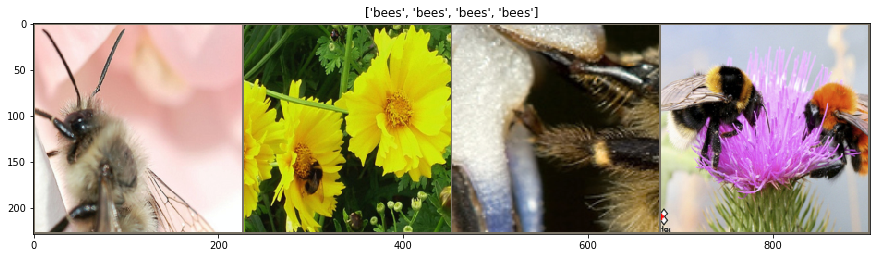

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Задача 1 (0.5 баллов)

Следующая функция будет использоваться для обучения модели. Аргументы:  
* model $-$ нейросеть
* criterion $-$ оптимизируемая функция (cost function, objective)
* optimizer $-$ оптимизационный алгоритм
* scheduler $-$ политика изменения learning_rate
* num_epochs $-$ количество итераций обучения

**Задание**: Вам нужно модифицировать эту функцию, чтобы она возвращала ещё и массивы loss'а на обучающей и валидационной выборках (чтобы потом Вы могли нарисовать графики). Можете модифицировать эту функцию как угодно, лишь юбы она правильно работала.

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, logs=True):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    is_this_loss = []

    for epoch in tqdm(range(num_epochs)):
        if logs:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            is_this_loss.append(epoch_loss)
            
            if logs:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        if logs:
            print()

    time_elapsed = time.time() - since
    if logs:
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        plt.plot(is_this_loss)

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, best_acc, is_this_loss

def eval_model(model, criterion):
    if use_gpu:
        model = model.cuda()

    running_corrects = 0
    running_loss = 0.0
    
    for data in dataloaders['val']:
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            l = criterion(outputs, labels)
            running_corrects += torch.sum(preds == labels.data)
            running_loss += l
        acc = running_corrects / dataset_sizes['val']
        loss = running_loss / dataset_sizes['val']
        print('Accuracy: ', acc)
        print('Loss: ', loss)

* Функция для отрисовки тестовых изображений и предсказаний для них:

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

### Задание (9 баллов)

Для каждой из следующих нейросетей:
* **AlexNet** (уже сделано в примере)
* **VGG16**
* **Inception_v3**
* **ResNet18**  

Напишите код и выведите результат (график лосса, accuracy и вывод примера классификации картинок с визализацией (с помощью функции `vizualize_model()`)) для трёх способов:
* Использование готовой нейросети **"из коробки"**
* Использование нейросети как **Feature Extractor**
* **Fine Tuning** нейросети

Для каждого пункта нужно:
* сделать с сетью то, что нужно в пункте ("из коробки", FE или FT)
* вывести график loss'а на обучающей и на валидационной выборке
* вывести качество модели (accuracy) на валидационной (тестовой) выборке
* (по желанию) использовать функцию visualize_model()

За одну комбинацию *сеть/способ* даётся **1 балл** (вывод результатов обязателен, иначе оценка будет 0 баллов).

### AlexNet

*ПРИМЕЧАНИЕ: Здесь не выведены графики loss'а и не использована visualize_model(). От Вас это ожидается.*

Загрузка модели:

In [8]:
model = models.alexnet(pretrained=True)

Посмотрим, что внутри:

In [6]:
model

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

Видим, что на вход классификатору (classifier) подаётся *9216 признаков*. Это и будет размер входа для нашего нового классификатора.

* **Fine Tuning** способ

Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:

(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

Видим, что Fine Tuning AlexNet'а не дал хороших результатов, поскольку качество получается 70%, что маловато для свёрточной нейросети для задачи классификации картинок. Посмотрим, как будет с AlexNet в роли Feature Extractor'а.

* **Feature Extractor** способ

Помним, что по-умолчанию все слои нейросети обучаются заново:

In [13]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Сделаем так, чтобы на них *не распространялся backpropagation* (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [14]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
criterion = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 1.2398 Acc: 0.7090
val Loss: 2.0266 Acc: 0.7908

Epoch 1/24
----------
train Loss: 1.9178 Acc: 0.7910
val Loss: 1.7832 Acc: 0.8431

Epoch 2/24
----------
train Loss: 1.1839 Acc: 0.8402
val Loss: 2.2884 Acc: 0.8170

Epoch 3/24
----------
train Loss: 1.1163 Acc: 0.8238
val Loss: 1.6928 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.8181 Acc: 0.8934
val Loss: 1.4027 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.7264 Acc: 0.8811
val Loss: 1.8818 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.5346 Acc: 0.9057
val Loss: 1.7154 Acc: 0.8301

Epoch 7/24
----------
train Loss: 0.3446 Acc: 0.9303
val Loss: 1.5377 Acc: 0.8562

Epoch 8/24
----------
train Loss: 0.3473 Acc: 0.9426
val Loss: 1.5425 Acc: 0.8497

Epoch 9/24
----------
train Loss: 0.5542 Acc: 0.9139
val Loss: 1.6020 Acc: 0.8366

Epoch 10/24
----------
train Loss: 0.2088 Acc: 0.9467
val Loss: 1.7559 Acc: 0.8235

Epoch 11/24
----------
train Loss: 0.3961 Acc: 0.9180
val Loss: 1.5529 Acc: 0.8497

Ep

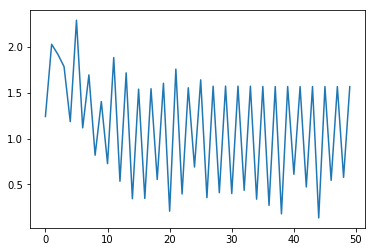

In [15]:
%%time
model_extractor = train_model(model_extractor, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

In [20]:
visualize_model(model_extractor)

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at d:\projects\pytorch\torch\lib\thc\generic/THCTensorCopy.c:18

Видим, что качество намного лучше - 90%.

**Вопрос (важный):** С чем связано такое повышение качества? (Подсказка: посмотрите на датасет и на то, как он согласуется с 4-мя ситуациями, описанными выше)

**Ответ (важный):** Спойлер: CNN смысла обучать после acc 67-70% нет. Она просто не учится, легче обучить классификатор

* Использование AlexNet **"из коробки"**:

### Задача 2 (0.5 балла)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

torch.cuda.set_device(torch.cuda.current_device())

def yield_x(phase):
    for data in dataloaders[phase]:
        yield data[0]

def yield_y(phase):
    for data in dataloaders[phase]:
        yield data[1]

def build_log(m, name):
    modes = ['ft', 'fe', 'ob']
    #modes = ['ob']
    logs = [{}, {}, {}]
    
    top_size = {'alexnet': 9216, 'inceptionV3': 2048, 'vgg16': 25088, 'resnet18': 512}
    
    for mode in modes:
        if mode == 'ft':
            print(name + '_ft')
            model = m(pretrained=True)
            # num_features -- это размерность вектора фич, поступающего на вход FC-слою
            num_features = top_size[name]
            # Заменяем Fully-Connected слой на наш линейный классификатор
            if name == 'alexnet' or name == 'vgg16':
                model.classifier = nn.Linear(num_features, 2)
            else:
                models.fc = nn.Linear(num_features, 2)

            # Использовать ли GPU
            if use_gpu:
                model = model.cuda()

            # В качестве cost function используем кросс-энтропию
            criterion = nn.CrossEntropyLoss()

            # В качестве оптимизатора - стохастический градиентный спуск
            optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

            # Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
            exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

            model, acc, loss_arr = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, logs=False)
            del(model)
            logs[0]['acc'] = acc
            logs[0]['loss_arr'] = loss_arr
            logs[0]['name'] = name + '_FT'
        if mode == 'fe':
            print(name + '_fe')
            model_extractor = m(pretrained=True)
            for param in model_extractor.parameters():
                param.requires_grad = False

            # num_features -- это размерность вектора фич, поступающего на вход FC-слою
            num_features = top_size[name]
            # Заменяем Fully-Connected слой на наш линейный классификатор
            if name == 'alexnet' or name == 'vgg16':
                model_extractor.classifier = nn.Linear(num_features, 2)
            else:
                model_extractor.fc = nn.Linear(num_features, 2)
            # Использовать ли GPU
            if use_gpu:
                model_extractor = model_extractor.cuda()

            # В качестве cost function используем кросс-энтропию
            criterion = nn.CrossEntropyLoss()

            # Обучаем только классификатор
            if name == 'alexnet' or name == 'vgg16':
                optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)
            else:
                optimizer = optim.SGD(model_extractor.fc.parameters(), lr=0.001, momentum=0.9)
            

            # Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
            exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            model, acc, loss_arr = train_model(model_extractor, criterion, optimizer, exp_lr_scheduler, num_epochs=25, logs=False)
            del(model_extractor)
            logs[1]['acc'] = acc
            logs[1]['loss_arr'] = loss_arr
            logs[1]['name'] = name + '_FE'
        if mode == 'ob':
            print(name + '_ob')
            model = m(pretrained=True)
            X_train = torch.FloatTensor(np.array([i[0].numpy() for i in dataloaders['train']]))
            if name == 'alexnet' or name == 'vgg16':
                bf = model.features
            else:
                bf = model[:-1]
            
            train_bottlenecks = []
            y_labels = []
            
            if False:
                bf = bf.cuda()
            
            for data in tqdm(dataloaders['train']):
                inputs, labels = data
                if False:
                    inputs = Variable(inputs.cuda())
                else:
                    inputs= Variable(inputs)
                outputs = model(inputs)
                outputs = outputs.data.numpy()
                train_bottlenecks.extend(outputs)
                y_labels.extend(labels.numpy())
            
            y_labels = []
            for i in yield_y('train'):
                y_labels.extend(i) 
            logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=322)
            logreg.fit(train_bottlenecks, y_labels)
            
            bottlenecks = []
            
            for data in tqdm(dataloaders['val']):
                inputs, labels = data
                inputs= Variable(inputs)
                outputs = model(inputs)
                outputs = outputs.data.numpy()
                bottlenecks.extend(outputs)
                
            y_hat_test = [logreg.predict(i.reshape(1, i.size)) for i in bottlenecks]
            
            test_labels = []
            for i in yield_y('val'):
                test_labels.extend(i)
            acc = accuracy_score(y_hat_test, test_labels)
            del(m)
            logs[2]['acc'] = acc
            logs[2]['name'] = name + '_OB'
    return logs

def log_multiple(models):
    logs = [bulid_log(model) for model in models]

            

In [10]:
model = models.alexnet
model_list = [(models.alexnet, 'alexnet'), (models.vgg16, 'vgg16'),
          (models.inception_v3, 'inceptionV3'), (models.resnet18, 'resnet18')]
print(build_log(models.resnet18, 'resnet18'))

resnet18_ft


  0%|          | 0/25 [00:00<?, ?it/s]


KeyboardInterrupt: 

**Задача:** Используйте AlexNet "из коробки" и выведите его точность (качество, accuracy) на тестовой выборке.

Ничегошеньки не меняем, просто используем:

In [ ]:
model_out_of_box.train(False)

eval_acc(model_out_of_box)

### Теперь Ваша очередь

**Вопрос:** Какую стратегию Вы выберете, учитывая размер и специфику нового датасета?

**Ответ:** <Ваш ответ>

### VGG16

### Inception_v3

In [9]:
model_extractor = models.inception_v3(pretrained=True)
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
criterion = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.fc.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_extractor = train_model(model_extractor, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


RuntimeError: Given input size: (128, 3, 3). Calculated output size: (4, -1, -1). Output size is too small.

### ResNet18

In [ ]:
# Ваш код здесь

**Вопрос:** Какая из сетей оказалась наилучшей?

**Ответ:** <Ваш ответ>